In [1]:
#IMPORTAMOS LAS LIBRERIAS A UTILIZAR
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy import stats
from scipy.optimize import minimize
from scipy.optimize import curve_fit
from astropy.modeling import models, fitting
from scipy import odr


import emcee
import corner

from urllib.error import HTTPError

from multiprocessing import Pool, cpu_count

# Estimación de Temperatura Pesada con $t^2 > 0$ 

In [2]:
## Cargarmos las Nuevas Tablas con los Nuevos datos:

total_abundances = pd.read_csv('total_abundances_t2geq0.txt', delim_whitespace = ' ')
ionic_abundances = pd.read_csv('ionic_abundances_t2geq0.txt', delim_whitespace = ' ')
physical_conditions = pd.read_csv('physical_conditions.txt', delim_whitespace = ' ')

#Filtrar las regiones por su nombre:

#Regiones HII:

total_HII_filter = total_abundances[total_abundances['File'].str.startswith('HII_')]
ionic_HII_filter = ionic_abundances[ionic_abundances['File'].str.startswith('HII_')]
physical_HII_filter = physical_conditions[physical_conditions['File'].str.startswith('HII_')]

#Regiones SFG:

total_SFG_filter = total_abundances[total_abundances['File'].str.startswith('SFG_')]
ionic_SFG_filter = ionic_abundances[ionic_abundances['File'].str.startswith('SFG_')]
physical_SFG_filter = physical_conditions[physical_conditions['File'].str.startswith('SFG_')]

print('Este es el número total de regiones HII:', len(total_HII_filter))
print('Este es el número total de regiones SFG:', len(total_SFG_filter))
print('Este es el número total de conjunto de HII y SFG:', len(total_HII_filter) + len(total_SFG_filter))

Este es el número total de regiones HII: 1263
Este es el número total de regiones SFG: 1459
Este es el número total de conjunto de HII y SFG: 2722


## Calcular $T_{heavy}$

Vamos a calcular $T_{pesada}$ y sus errores usando propagación de errores.

La formula para $T_{pesada}$ es:


$$ T_{pesada} = \dfrac{O3_{abundance}}{O_{abundance}}Te[OIII] + \dfrac{O2_{abundance}}{O_{abundance}}Te[NII] $$

Tenemos que recordar que por definición tenemos las siguientes relaciones importantes:

$$ Log\left( \dfrac{O3}{H} \right) + 12 = O3_{abundance} $$


$$ Log\left( \dfrac{O2}{H} \right) + 12 = O2_{abundance} $$

$$ Log\left( \dfrac{O}{H} \right) + 12 = O_{abundance} $$

Expresando la expresión en escala lineal tenemos que:

$$ T_{pesada} = 10^{(O3_{abundance} - O_{abundance})}Te[OIII] + 10^{(O2_{abundance} - O_{abundance})}Te[NII]$$

Total de Regiones SFG: 44
Total de Regiones HII: 230
Total de Regiones a estudiar: 274


<IPython.core.display.Javascript object>


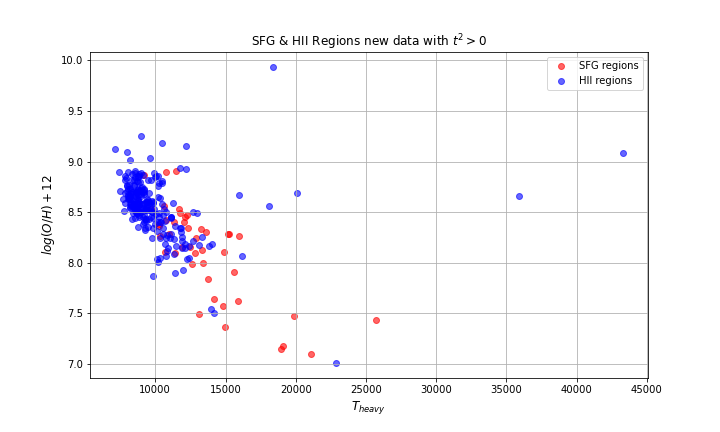

In [3]:
#Vamos a crear mascaras para cada una de las regiones:

#SFG:
mask = ~np.isnan(ionic_SFG_filter['O3_abundance']) & ~np.isnan(total_SFG_filter['O_abundance'])& \
        ~np.isnan(physical_SFG_filter['Te_[OIII]_4363_5007']) &~np.isnan(ionic_SFG_filter['O2_abundance'])\
        &~np.isnan(physical_SFG_filter['Te_[NII]_5755_6584']) &~ np.isnan(physical_SFG_filter['e_Te_[OIII]_4363_5007m'])\
        &~ np.isnan(physical_SFG_filter['e_Te_[OIII]_4363_5007p']) & ~np.isnan(physical_SFG_filter['e_Te_[NII]_5755_6584m'])\
        & ~np.isnan(physical_SFG_filter['e_Te_[NII]_5755_6584p'])

#HII:
mask2 = ~np.isnan(ionic_HII_filter['O3_abundance']) & ~np.isnan(total_HII_filter['O_abundance'])& \
        ~np.isnan(physical_HII_filter['Te_[OIII]_4363_5007']) &~np.isnan(ionic_HII_filter['O2_abundance'])& \
        ~np.isnan(physical_HII_filter['Te_[NII]_5755_6584']) &~ np.isnan(physical_HII_filter['e_Te_[OIII]_4363_5007m'])& \
        ~np.isnan(physical_HII_filter['e_Te_[OIII]_4363_5007p']) & ~np.isnan(physical_HII_filter['e_Te_[NII]_5755_6584m'])& \
        ~np.isnan(physical_HII_filter['e_Te_[NII]_5755_6584p'])

#Esta función determina T_{heavy} a partir de las abudancias totales e ionicas de O y de sus Temperaturas.

#DETERMINA LOS VALORES CENTRALES DE T_{Heavy}:

def T_heavy(O3, O2, O, Te_O3, Te_Ne): #Definimos nuestra función de T_pesada
    T = 10**(O3 - O)*Te_O3 + 10**(O2 - O)*Te_Ne
    return round(T,2)

T_SFG = T_heavy(ionic_SFG_filter['O3_abundance'][mask],ionic_SFG_filter['O2_abundance'][mask], \
                total_SFG_filter['O_abundance'][mask], physical_SFG_filter['Te_[OIII]_4363_5007'][mask],\
                physical_SFG_filter['Te_[NII]_5755_6584'][mask])

T_HII = T_heavy(ionic_HII_filter['O3_abundance'][mask2],ionic_HII_filter['O2_abundance'][mask2], \
                total_HII_filter['O_abundance'][mask2], physical_HII_filter['Te_[OIII]_4363_5007'][mask2],\
                physical_HII_filter['Te_[NII]_5755_6584'][mask2])

print(r'Total de Regiones SFG:', len(T_SFG)) #DATOS DE TEMPERATURA PESADA PARA LAS REGIONES SFG
print(r'Total de Regiones HII:', len(T_HII)) #DATOS DE TEMPERATURA PESADA PARA LAS REGIONES HII

print(r'Total de Regiones a estudiar:' ,len(T_SFG)+ len(T_HII))

### Vamos a visualizar nuestras regiones de forma general para observar su comportamiento:
fig, ax = plt.subplots(figsize=(10,6))

ax.scatter(T_SFG, total_SFG_filter['O_abundance'][mask],  c = 'r', label = 'SFG regions', alpha = 0.6)
ax.scatter(T_HII, total_HII_filter['O_abundance'][mask2], c = 'b', label = r'HII regions', alpha = 0.6)
ax.set_title('SFG & HII Regions new data with $t^2 > 0$')
ax.set_ylabel(r'$log(O/H) + 12$', size = 12)
ax.set_xlabel(r'$T_{heavy}$', size = 12)
plt.grid(True)
plt.legend()
plt.savefig('SFG_&_HII_Regions_with_NewData_t2geq0', dpi = 500)

In [4]:
### Contatenar:

#SFG:
Data_SFG = {'Name': total_SFG_filter['File'][mask],'O3_abundance': ionic_SFG_filter['O3_abundance'][mask], 
            'O2_abundance': ionic_SFG_filter['O2_abundance'][mask],'O_abundance': total_SFG_filter['O_abundance'][mask],
            'e_O_abundancem': total_SFG_filter['e_O_abundancem'][mask],
            'e_O_abundancep': total_SFG_filter['e_O_abundancep'][mask],
            'Te_[OIII]': physical_SFG_filter['Te_[OIII]_4363_5007'][mask], 
            'e_Te_[OIII]m':physical_SFG_filter['e_Te_[OIII]_4363_5007m'][mask],
            'e_Te_[OIII]p':physical_SFG_filter['e_Te_[OIII]_4363_5007p'][mask], 
            'Te_[NeII]': physical_SFG_filter['Te_[NII]_5755_6584'][mask],
            'e_Te_[NeII]m': physical_SFG_filter['e_Te_[NII]_5755_6584m'][mask],
            'e_Te_[NeII]p': physical_SFG_filter['e_Te_[NII]_5755_6584p'][mask],  
            'T_heavy': T_SFG}
df_SFG = pd.DataFrame(Data_SFG)

#HII:

Data_HII = {'Name': total_HII_filter['File'][mask2],'O3_abundance': ionic_HII_filter['O3_abundance'][mask2], 
            'O2_abundance': ionic_HII_filter['O2_abundance'][mask2],'O_abundance': total_HII_filter['O_abundance'][mask2],
            'e_O_abundancem': total_HII_filter['e_O_abundancem'][mask2],
            'e_O_abundancep': total_HII_filter['e_O_abundancep'][mask2], 
            'Te_[OIII]': physical_HII_filter['Te_[OIII]_4363_5007'][mask2],
            'e_Te_[OIII]m':physical_HII_filter['e_Te_[OIII]_4363_5007m'][mask2],
            'e_Te_[OIII]p':physical_HII_filter['e_Te_[OIII]_4363_5007p'][mask2],
            'Te_[NeII]': physical_HII_filter['Te_[NII]_5755_6584'][mask2], 
            'e_Te_[NeII]m': physical_HII_filter['e_Te_[NII]_5755_6584m'][mask2],
            'e_Te_[NeII]p': physical_HII_filter['e_Te_[NII]_5755_6584p'][mask2],
            'T_heavy': T_HII}

df_HII = pd.DataFrame(Data_HII)

print(len(df_SFG) + len(df_HII)) #Vemos si tenemos los mismos datos

#Concatenar:

df_new = pd.concat([df_SFG, df_HII])
df_new = df_new.reset_index()

274


In [39]:
### ESTA FUNCIÓN DETERMINA LOS ERRORES DE T_{Heavy} para cada uno de los datos a partir de un metodo MonteCarlo

def e_T_heavy(O3, O2, O, Te_O3, Te_Ne, e_Te_O3m, e_Te_O3p, e_Te_Nem, e_Te_Nep):
    
    #Número de muestras MonteCarlo
    n_samples = 10000
    
    #Listas vacias:

    e_T_list = [] #Arreglo vacio que almacenará los datos del error minus
    E_T_list = [] #Arreglo vacio que almacenará los datos del error plus

    #Vamos a crear una serie de simulaciones MonteCarlo para cada row de nuestro dataframe:
    
    for i in range(len(O3)):         
    
        #Hacemos una simulación MonteCarlo de 100000 muestras para cada Row de nuestro dataframe
        
        T_samples = np.random.standard_normal(n_samples)
        
        ##Primer termino de nuestra Ecuación de T_pesada:
        T_heavy1 = T_samples*(e_Te_O3m[i]/2 + e_Te_O3p[i]/2)*10**(O3[i] - O[i]) + 10**(O3[i] - O[i])*Te_O3[i]
        
        ##Primer termino de nuestra Ecuación de T_pesada:
        T_heavy2 = T_samples*(e_Te_Nem[i]/2 + e_Te_Nep[i]/2)*10**(O2[i] - O[i]) + 10**(O2[i] - O[i])*Te_Ne[i]   
    
        T_sum = T_heavy1 + T_heavy2   ##Suma de los terminos de nuestra función
    
        T_central = np.median(T_sum)
    
    
    
        e_Thp = round(np.percentile(T_sum, 84) - T_central,2)
        e_Thm = round(T_central - np.percentile(T_sum, 16),2)
        
        #Concatenar:
    
        e_T_list = np.append(e_T_list, np.absolute(e_Thm))
        E_T_list = np.append(E_T_list, np.absolute(e_Thp))
    
    
    return (e_T_list, E_T_list)

#Asignamos nuestros datos a una variable:

O3 = df_new['O3_abundance']
O2 = df_new['O2_abundance']
O = df_new['O_abundance']
Te_O3 = df_new['Te_[OIII]']
Te_Ne = df_new['Te_[NeII]']
e_Te_O3m = df_new['e_Te_[OIII]m']
e_Te_O3p = df_new['e_Te_[OIII]p']
e_Te_Nem = df_new['e_Te_[NeII]m']
e_Te_Nep = df_new['e_Te_[NeII]p']

e_T_total = e_T_heavy(O3, O2, O, Te_O3, Te_Ne, e_Te_O3m, e_Te_O3p, e_Te_Nem, e_Te_Nep)

df_new['e_T'], df_new['E_T'] = e_T_total[0], e_T_total[1]

### Notamos que tenemos datos outliers, vamos a quitarlos:

outlier = df_new[(df_new['O_abundance'] > 8.51) & (df_new['O_abundance'] < 10) & (df_new['T_heavy'] > 1.49e4) &\
                  (df_new['T_heavy'] < 5e4)]
outlier2 = df_new[(df_new['e_O_abundancem'] > 0.9) & (df_new['e_O_abundancem'] < 10)]

#outlier3 = df_new[(df_new['O_abundance'] > 6.9) & (df_new['O_abundance'] < 7.1) & (df_new['T_heavy'] > 1.6e4) &\
                  #(df_new['T_heavy'] < 2.5e4)]
#outlier4 = df_new[(df_new['O_abundance'] > 7.4) & (df_new['O_abundance'] < 7.5) & (df_new['T_heavy'] > 1.9e4) &\
                 #(df_new['T_heavy'] < 2e4)]
    

df_new2 = df_new.drop(outlier.index)
df_new2 = df_new2.drop(outlier2.index)
#df_new2 = df_new2.drop(outlier3.index)
#df_new2 = df_new2.drop(outlier4.index)
df_new2 = df_new2.reset_index(drop = True)



##Error en y:
yerr = [df_new2['e_O_abundancem'], df_new2['e_O_abundancep']]

##Error en x:
xerr = [df_new2['e_T'], df_new2['E_T']]
#df_new2
#outlier3

In [64]:
df_new2

,index,Name,O3_abundance,O2_abundance,O_abundance,e_O_abundancem,e_O_abundancep,Te_[OIII],e_Te_[OIII]m,e_Te_[OIII]p,Te_[NeII],e_Te_[NeII]m,e_Te_[NeII]p,T_heavy,e_T,E_T
0,2082,SFG__HS0924+3821__HS0924+3821__Izotov__04__,7.931,7.286,7.996,0.308,0.324,12439.46,166.32,215.27,13892.29,1880.81,2972.46,13419.08,626.08,645.65
1,2086,SFG__HS1213+3636A__HS1213+3636A__Izotov__04__,7.890,7.691,8.099,0.193,0.192,10652.44,274.57,229.38,12419.14,2017.19,1961.03,11437.29,958.01,901.19
2,2092,SFG__HS1851p6933__HS1851p6933__Izotov__21b__,8.241,7.025,8.266,0.033,0.033,16134.06,367.09,329.49,12199.87,441.41,289.62,15931.95,349.70,342.03
3,2096,SFG__HS2359+1659__HS2359+1659__Izotov__04__,7.447,6.524,7.496,0.311,0.272,11789.52,182.91,149.05,24306.05,5360.83,7415.31,13124.12,841.62,833.85
4,2099,SFG__Haro11__Haro11B__Guseva__12__,7.975,7.541,8.110,0.014,0.015,10032.83,75.34,61.70,12333.11,191.28,167.24,10679.46,95.04,100.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260,1231,HII__SMC__NGC456-2__PenaGuerrero__12__,8.214,7.544,8.300,0.122,0.120,12089.50,266.08,151.26,11075.73,841.30,955.03,11860.19,335.27,324.40
261,1233,HII__SMC__NGC456-a-1__Guseva__11__,8.121,7.667,8.255,0.076,0.073,12167.86,95.71,105.28,11514.88,713.10,717.38,11910.90,257.18,262.44
262,1236,HII__SMC__NGC456-a-3-m__Guseva__11__,8.047,7.471,8.144,0.093,0.090,11951.43,81.23,96.14,12031.53,1079.28,997.38,12113.75,287.14,289.01
263,1237,HII__SMC__NGC456-a1__Guseva__11__,8.044,7.635,8.187,0.039,0.045,12176.60,79.81,87.73,11883.36,327.49,461.32,12094.24,170.62,170.54


<IPython.core.display.Javascript object>


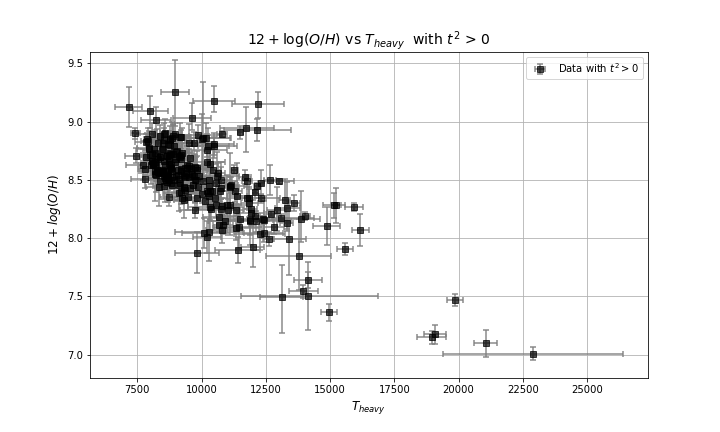

In [40]:
### Vamos a visualizar los datos

fig, ax = plt.subplots(figsize=(10,6))

ax.errorbar(df_new2['T_heavy'],df_new2['O_abundance'], xerr = xerr, yerr = yerr,fmt ='s', c = 'k', elinewidth = 2, 
            capsize=3, capthick = 2, ecolor= 'grey', label = r'Data with $t^{2} >0$', alpha = 0.7)
ax.set_ylabel('$12 + log(O/H)$', size = 12)
ax.set_xlabel('$T_{heavy}$', size = 12)
ax.set_title('$12 + \log(O/H)$ vs $T_{heavy}$  with $t^2$ > 0', size = 14)
plt.grid(True)
plt.legend()
ax.set_ylim(6.8, 9.6)
plt.savefig('Scatter_Data_OvsTheavy_with_NewData_t2geq0', dpi = 500)

## Ajuste Lineal Considerando errores en Log(O/H) y en $T_{heavy}$ 
### Ajuste Lineal ODR y Linregrees para todos los datos en conjunto:

In [41]:
#Esta funcion es para hacer ajustes lineales considerando barras de error tanto en eje x como en el eje y:

def linfit(x, y, xerr_low, xerr_high, yerr_low, yerr_high):
    
    #Definemos nuestros errores como:
    
    x_e = (xerr_low + xerr_high)/2
    y_e = (yerr_low + yerr_high)/2
    
    #definimos la forma de la funcion que queremos ajustar
    def func(p, x):

        m,b = p
        return m*x + b
 
    quad_model = odr.Model(func)
    
    # Create a RealData object
    data = odr.RealData(x, y, sx=x_e, sy=y_e)

    # Set up ODR with the model and data.
    odr_instance = odr.ODR(data, quad_model, beta0=[1., 1.])

    # Run the regression.
    out = odr_instance.run()

    #print fit parameters and 1-sigma estimates
    popt = out.beta
    perr = out.sd_beta
  
    c=popt[1]
    e_c=perr[1]
    
    m=popt[0]
    e_m=perr[0]

    # Calculate Pearson correlation coefficient
    correlation_coefficient, _ = stats.pearsonr(x, y)
    
    return  c, e_c, m, e_m, correlation_coefficient
#Eje x:

O = np.linspace(min(df_new2['T_heavy']), max(df_new2['T_heavy']), len(df_new2['T_heavy']))

#Ajuste ODR:

adjustment = linfit(df_new2['T_heavy'], df_new2['O_abundance'],df_new2['e_T'],df_new2['E_T'],
                    df_new2['e_O_abundancem'],df_new2['e_O_abundancep'])

print('Estos son los parametros del ajuste ODR:', adjustment)

#Linregess:

linre = stats.linregress(df_new2['T_heavy'], df_new2['O_abundance'])

print('Estos son los parametros del ajuste Linregress:', linre)

Estos son los parametros del ajuste ODR: (9.632086731579616, 0.05589998436707418, -0.0001151191599382601, 5.557125106449592e-06, -0.7681107680449984)
Estos son los parametros del ajuste Linregress: LinregressResult(slope=-0.00011492470793107589, intercept=9.65242824244822, rvalue=-0.7681107680449987, pvalue=7.707005363344326e-53, stderr=5.90754048526475e-06, intercept_stderr=0.061708194939411834)


<IPython.core.display.Javascript object>


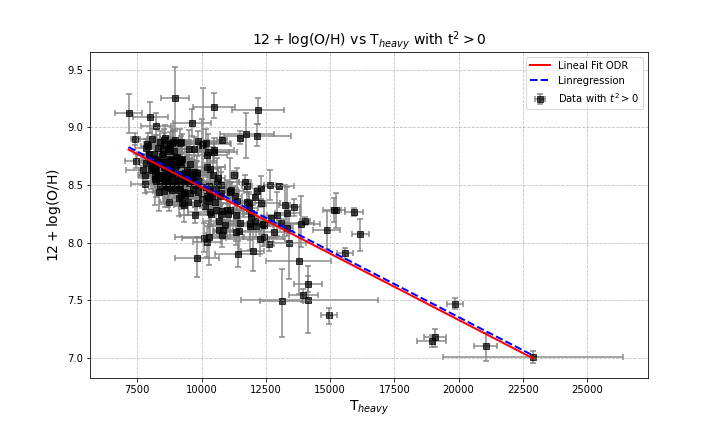

Slope ORD: -0.000115 ± 0.000006
Intercept ORD: 9.632087 ± 0.055900
Slope Linregress: -0.000115 ± 0.000006
Intercept Linregress:  9.6524 ± 0.0617


In [89]:
#Graficamos:

fig, ax = plt.subplots(figsize=(10,6))

ax.errorbar(df_new2['T_heavy'], df_new2['O_abundance'], xerr = xerr, yerr = yerr,fmt ='s', c = 'k', elinewidth = 2, 
            capsize=3, capthick = 2, ecolor= 'grey', label = 'Data with $t^2 > 0$', alpha = 0.7, zorder = 1)

# Intervalo de confianza (aproximado)
y_fit_upper = (adjustment[2] + adjustment[3]) *O + (adjustment[0] + adjustment[1])
y_fit_lower = (adjustment[2] - adjustment[3]) *O + (adjustment[0] - adjustment[1])

plt.plot(O, np.dot( np.vander(O, 2), [adjustment[2], adjustment[0]] ), c = 'r', label = 'Lineal Fit ODR', lw = 2, zorder = 2)

plt.plot(O, np.dot(np.vander(O, 2), [linre[0], linre[1]] ), '--', c = 'b', label = 'Linregression', lw = 2, zorder = 2)

print(f"Slope ORD: {adjustment[2]:.6f} ± {adjustment[3]:.6f}")
print(f"Intercept ORD: {adjustment[0]:.6f} ± {adjustment[1]:.6f}")

print(f'Slope Linregress: {linre[0]: .6f} ± {linre[4]:.6f}')
print(f'Intercept Linregress: {linre[1]: .4f} ± {0.06170819:.4f}')


ax.set_ylabel('$12 + \log$(O/H)', size = 14)
ax.set_xlabel('T$_{heavy}$', size = 14)
ax.set_title('$12 + \log$(O/H) vs T$_{heavy}$ with t$^2 > 0$', size = 14)
plt.grid(True, linestyle = '--', alpha = 0.8)
plt.legend(loc = 'upper right', fontsize = 'medium')
plt.savefig('LinealAdjustments_Theavy_vs_O_with_NewData_t2geq0', dpi = 300)

#### Residuos:

<IPython.core.display.Javascript object>


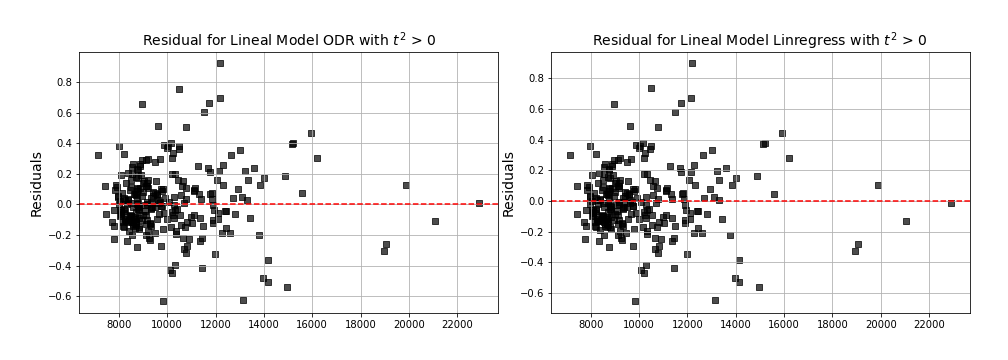

In [92]:
### Haremos el calculo de los residuos y ambos modelos y los vamos a comparar:

y_obs = df_new2['O_abundance']

#Residual ODR:

#Definimos la función para determinar los residuos de ODR:

y = adjustment[0] + adjustment[2]*df_new2['T_heavy']

Residual_ODR = y_obs - y

#Residual Linregress: 

#Definimos la función para determinar los residuos de Linregress:

y2 = linre[0]*df_new2['T_heavy'] + linre[1]

Residual_Linregress = y_obs - y2

#Graficamos:

fig, ax = plt.subplots(1,2, figsize= (14,5))


ax[0].scatter(df_new2['T_heavy'], Residual_ODR, color='black',marker = 's', alpha=0.7)
ax[0].axhline(0, color='red', linestyle='dashed')
ax[0].set_ylabel("Residuals", size = 14)
ax[0].set_title("Residual for Lineal Model ODR with $t^2$ > 0", size = 14)
#ax[0].set_ylim(-5000, 5000)
ax[0].grid(True)

fig.tight_layout(pad=3)

ax[1].scatter(df_new2['T_heavy'], Residual_Linregress, color='black', marker = 's', alpha=0.7)
ax[1].axhline(0, color='red', linestyle='dashed')
ax[1].set_ylabel("Residuals", size = 14)
ax[1].set_title("Residual for Lineal Model Linregress with $t^2$ > 0 ", size = 14)
#ax[1].set_ylim(-5000, 5000)
ax[1].grid(True)
plt.savefig('Residual_ODR&Linregress_with_NewData_t2geq0', dpi = 300)

## Resultados del modelo:

$$ 12 + \log_{10}(O/H) = (9.632293 \pm 0.055912) - (0.000115 \pm 0.000006)Te $$

Tambien se puede escribir como:

$$ 12 + \log_{10}(O/H) = (9.63 \pm 0.05) - (1.15 \pm 0.06) \dfrac{T_e}{10^4 K} $$

### Ajuste Lineal MCMC:

In [15]:
#Definimos nuestra nueva likelihood:

#def log_likelihood(theta, x, y, em_y, ep_y, em_x, ep_x):
    
 #   xerr = (em_x + ep_x)/2
  #  yerr = (em_y + ep_y)/2
    
   # m, b= theta
    #model = m * x + b
    #sigma2 = (yerr**2 + (m*xerr)**2)
    #return -0.5 * np.sum((y - model) ** 2/sigma2 + np.log(2*np.pi*sigma2))

#np.random.seed(128)
#nll = lambda *args: -log_likelihood(*args)
#initial = np.array([-8600,83500]) + 1* np.random.randn(2)
#soln = minimize(nll, initial, args=(df_new2['O_abundance'], df_new2['T_heavy'], df_new2['e_T'], df_new2['E_T'],
 #                                   df_new2['e_O_abundancem'], df_new2['e_O_abundancep']))
#m_ml, b_ml  = soln.x

#print("Maximum likelihood estimates:")
#print("m = {0:.3f}".format(m_ml))
#print("b = {0:.3f}".format(b_ml))

In [16]:
#def log_prior(theta):
 #   m, b= theta
  #  if - 9339 < m < -7039 and  68022 < b < 90022:
   #     return 0.0
    #return -np.inf

#Combinando log_prior y log_likelihood obtenemos the full log-probability function:

#def log_probability(theta, x, y,em_y, ep_y, em_x, ep_x):
 #   lp = log_prior(theta)
  #  if not np.isfinite(lp):
   #     return -np.inf
    #return lp + log_likelihood(theta, x, y, em_y, ep_y, em_x, ep_x)

In [23]:
#pos = soln.x + 1*np.random.randn(32, 2)
#nwalkers, ndim = pos.shape

#ncpu = cpu_count()
#print("{0} CPUs".format(ncpu))

#with Pool(processes=15) as pool:
 #   sampler = emcee.EnsembleSampler(
  #  nwalkers, ndim, log_probability, args=(df_new2['O_abundance'], df_new2['T_heavy'], df_new2['e_T'], df_new2['E_T'], 
                                           #df_new2['e_O_abundancem'], df_new2['e_O_abundancep']), pool = pool)
   # sampler.run_mcmc(pos, 5000, progress=True);

In [24]:
#fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
#samples = sampler.get_chain()
#labels = ["Slope", "Intercept"]
#for i in range(ndim):
 #   ax = axes[i]
  #  ax.plot(samples[:, :, i], "k", alpha=0.3)
   # ax.set_xlim(0, len(samples))
    #ax.set_ylabel(labels[i])
    #ax.yaxis.set_label_coords(-0.1, 0.5)

#axes[-1].set_xlabel("step number");

In [25]:
#flat_samples = sampler.get_chain(discard=50, thin=2, flat=True)
#print(flat_samples.shape)

#fig = corner.corner(flat_samples, labels=labels, truths=[soln.x[0], soln.x[1]], quantiles=(0.16, 0.84),levels=(0.68,0.95),
 #                   smooth= 1, show_titles = True, max_n_ticks = 4, title_kwargs={"fontsize": 12},color="black",
  #                  scale_hist = True);
#fig.tight_layout(pad=1)
#plt.savefig('CornerPlot_Lineal_Theavy_vs_O_ML_with_NewData_t2eq0', dpi = 500)

In [26]:
### GRAFICO:
#fig, ax = plt.subplots(figsize=(12,6))

#ax.errorbar(df_new2['O_abundance'], df_new2['T_heavy'], xerr = xerr, yerr = yerr,fmt ='s', c = 'k', elinewidth = 2, 
 #           capsize=3, capthick = 2, ecolor= 'grey', label = 'Data with $t^2 > 0$', alpha = 0.7, zorder = 1)

#inds = np.random.randint(len(flat_samples), size=1000)
#for ind in inds:
 #   sample = flat_samples[ind]
  #  plt.plot(df_new2['O_abundance'], np.dot(np.vander(df_new2['O_abundance'], 2), sample[:2]), "C1", c = 'Yellow',
   #          alpha=0.3)
    
#plt.plot(O, np.dot(np.vander(O, 2) , [soln.x[0], soln.x[1]]),   '--',c = 'r', zorder = 4,
 #        label = 'Maximum Likelihood Lineal Fit')



#ax.set_xlabel(r'$log(O/H) + 12$', size = 12)
#ax.set_ylabel(r'$T_{heavy}$', size = 12)
#ax.set_title('$T_{heavy}$ vs $\log(O/H)$ + 12 with $t^2 > 0$', size = 16)
#plt.grid(True)
#plt.legend()
#plt.savefig('LinealAdjustments_ML_Theavy_vs_O_with_NewData_t2eq0', dpi = 500)

In [27]:
### Residuos de ML:

#Residual_ML = y_obs - ( np.dot(np.vander(df_new2['O_abundance'], 2), [soln.x[0], soln.x[1]]) )

#Graficamos:

#fig, ax = plt.subplots(figsize= (12,7))

#ax.scatter(df_new2['O_abundance'], Residual_ML, color='black', marker = 's', alpha=0.7)
#ax.axhline(0, color='red', linestyle='dashed')
#ax.set_ylabel("Residual")
#ax.set_title("Residual for Maximum Likelihood Lineal Fit with $t^2 > 0$")
#ax[0].set_ylim(-5000, 5000)
#ax.grid(True)

#plt.savefig('Residual_Lineal_Maximun_Likelihood_with_NewData_t2geq0', dpi = 500)

## Ajuste Cuadratico

### Ajuste Cuadratico ODR y Polyfit

In [91]:
#esta funcion es para hacer ajustes cuadraticos considerando barras de error
def linfit2(x, y, xerr_low, xerr_high, yerr_low, yerr_high): #definimos función
    
    #Definemos nuestros errores como:
    
    x_e = (xerr_low + xerr_high)/2
    y_e = (yerr_low + yerr_high)/2
    
    #definimos la forma de la funcion que queremos ajustar, en este caso, cuadratica
    def quadratic(theta,x):
        a, b, c = theta
        model = a*x**2 + b*x + c
        return model
 
    quad_model = odr.Model(quadratic)
    
    # Create a RealData object
    data = odr.RealData(x, y, sx=x_e, sy=y_e)

    # Set up ODR with the model and data.
    odr_instance = odr.ODR(data, quad_model, beta0=[1,1,1])

    # Run the regression.
    out = odr_instance.run()

    #print fit parameters and 1-sigma estimates
    popt = out.beta
    perr = out.sd_beta
    
    a=popt[0]
    e_a=perr[0]
    
    b=popt[1]
    e_b=perr[1]
    
    c = popt[2]
    e_c = perr[2]
    


    # Calculate Pearson correlation coefficient
    correlation_coefficient, _ = stats.pearsonr(x, y)
    
    return  a, e_a, b, e_b, c, e_c, correlation_coefficient

#Hacemos nuestro ajuste cuadratico:

quadratic = linfit2(df_new2['T_heavy'], df_new2['O_abundance'],df_new2['e_T'],df_new2['E_T'], df_new2['e_O_abundancem'],
                    df_new2['e_O_abundancep']) #Le damos los valores a la función

print('Estos son los resultados de nuestro ajuste cuadratico ODR:', quadratic)

#Polifit:

poly = np.polyfit(df_new2['T_heavy'], df_new2['O_abundance'], 2)
print(poly)

Estos son los resultados de nuestro ajuste cuadratico ODR: (-1.392231501347919e-09, 1.4981457170534087e-09, -8.231387044878778e-05, 3.499107061101433e-05, 9.44895447670269, 0.19797805779096547, -0.7681107680449984)
[-1.18436569e-09 -8.49218983e-05  9.47580239e+00]


<IPython.core.display.Javascript object>


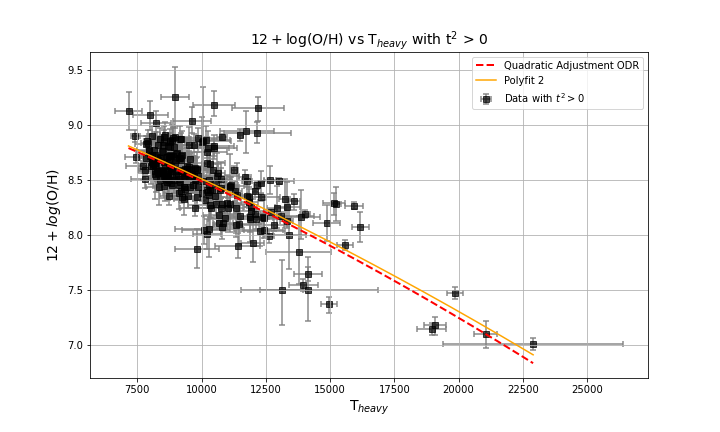

ORD a: -0.00000000139 ± 0.00000000150
ORD b: -0.00008231387 ± 0.00003499107
ORD c: 9.44895447670 ± 0.19797805779
Poly a: -0.0000000012
Poly b: -0.0000849219
Poly c: 9.4758023937
Podemos observar que el mejor ajuste para los datos el polyfit


In [99]:
#Graficamos:

fig, ax = plt.subplots(figsize=(10,6))

ax.errorbar(df_new2['T_heavy'], df_new2['O_abundance'], xerr = xerr, yerr = yerr,fmt ='s', c = 'k', elinewidth = 2, 
            capsize=3, capthick = 2, ecolor= 'grey', label = r'Data with $t^2 > 0$', alpha = 0.7, zorder = 1)

plt.plot(O, np.dot(np.vander(O, 3), [quadratic[0],quadratic[2], quadratic[4]]),'--', c = 'r', lw = 2, \
         label = 'Quadratic Adjustment ODR',  zorder = 2)


plt.plot(O, np.dot(np.vander(O,3), [poly[0], poly[1],poly[2]]), c = 'Orange', label = 'Polyfit 2')

print(f"ORD a: {quadratic[0]:.11f} ± {quadratic[1]:.11f}") #Valor de a y su error
print(f"ORD b: {quadratic[2]:.11f} ± {quadratic[3]:.11f}") #Valor de b y su error
print(f"ORD c: {quadratic[4]:.11f} ± {quadratic[5]:.11f}") #Valor de c y sy error

print(f"Poly a: {poly[0]:.10f}")
print(f"Poly b: {poly[1]:.10f}")
print(f"Poly c: {poly[2]:.10f}")


ax.set_ylabel('$12 + log$(O/H)', size = 14)
ax.set_xlabel('T$_{heavy}$', size = 14)
ax.set_title('$12 + \log$(O/H) vs T$_{heavy}$ with t$^2$ > 0', size = 14)
plt.grid(True)
plt.legend()
plt.savefig('Quadratic_Adjustment_OvsTheavy_t2geq0', dpi = 300)

print('Podemos observar que el mejor ajuste para los datos el polyfit')

#### Residuos:

<IPython.core.display.Javascript object>


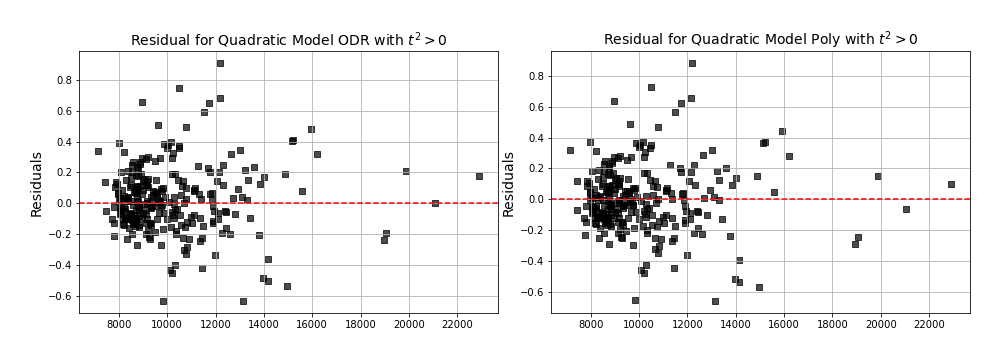

In [98]:
### Haremos el calculo de los residuos y ambos modelos y los vamos a comparar:


## Residuos ajuste cuadratico ODR:

Residual_Quadratic = y_obs - ( np.dot(np.vander(df_new2['T_heavy'], 3), [quadratic[0],quadratic[2], quadratic[4]]) )

## Residuios Ajuste PolyFit:

Residual_Quadratic_Poly = y_obs - ( np.dot(np.vander(df_new2['T_heavy'], 3), [poly[0], poly[1], poly[2]] ) )


#Graficamos:

fig, ax = plt.subplots(1,2, figsize= (14,5))



ax[0].scatter(df_new2['T_heavy'], Residual_Quadratic, color='black', marker = 's', alpha=0.7)
ax[0].axhline(0, color='red', linestyle='dashed')
ax[0].set_ylabel("Residuals", size = 14)
ax[0].set_title("Residual for Quadratic Model ODR with $t^2 > 0$", size = 14)
#ax.set_ylim(-5000, 5000)
ax[0].grid(True)

fig.tight_layout(pad=3)

ax[1].scatter(df_new2['T_heavy'], Residual_Quadratic_Poly, color='black', marker = 's', alpha=0.7)
ax[1].axhline(0, color='red', linestyle='dashed')
ax[1].set_ylabel("Residuals", size = 14)
ax[1].set_title("Residual for Quadratic Model Poly with $t^2 > 0$", size = 14)
#ax.set_ylim(-5000, 5000)
ax[1].grid(True)
plt.savefig('Residuals_QuadraticFit_ODR&Poly', dpi = 300)

<ipython-input-57-5aff65182077>:26: RuntimeWarning: invalid value encountered in divide
  result_average=weighted_mean.statistic / weights_sum.statistic
<ipython-input-57-5aff65182077>:32: RuntimeWarning: invalid value encountered in divide
  std_dev = np.sqrt((stats.binned_statistic(Xval, Yval ** 2 / (eYval ** 2),
<ipython-input-57-5aff65182077>:34: RuntimeWarning: invalid value encountered in divide
  (weighted_mean.statistic / weights_sum.statistic) ** 2)
<ipython-input-57-5aff65182077>:32: RuntimeWarning: invalid value encountered in sqrt
  std_dev = np.sqrt((stats.binned_statistic(Xval, Yval ** 2 / (eYval ** 2),


<IPython.core.display.Javascript object>


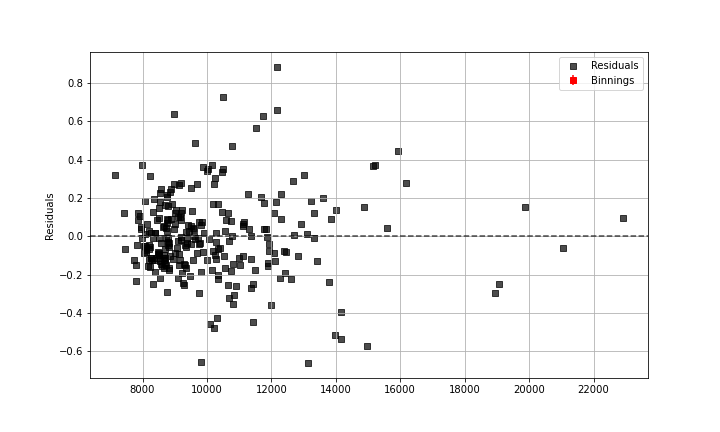

/home/idies/miniconda3/envs/py38/lib/python3.8/site-packages/matplotlib/axes/_base.py:2141: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


In [57]:
#Hacemos binning considerando el peso de los errores
def binning(Xval, em_x, ep_x,  Yval, em_y, ep_y, bin_size):
    
    eXval = (em_x + ep_x)/2
    eYval = (em_y + ep_y)/2

    # Remover np.nan de los datos
    valid_indices = ~np.isnan(Xval) & ~np.isnan(eXval) & ~np.isnan(Yval) & ~np.isnan(eYval)
   
    Xval = Xval[valid_indices]
    eXval = eXval[valid_indices]
    Yval = Yval[valid_indices]
    eYval = eYval[valid_indices]

    
    # Calcular el promedio ponderado por el inverso del cuadrado del error y la desviación estándar
    weighted_mean = stats.binned_statistic(Xval, Yval / (eYval ** 2),
                                     bins=np.arange(Xval.min(), Xval.max() + bin_size, bin_size), statistic='sum')
    
    
    weights_sum = stats.binned_statistic(Xval, 1 / (eYval ** 2),
                                   bins=np.arange(Xval.min(), Xval.max() + bin_size, bin_size), statistic='sum')



    result_average=weighted_mean.statistic / weights_sum.statistic
    
    
    # Calcular la desviación 
    
    
    std_dev = np.sqrt((stats.binned_statistic(Xval, Yval ** 2 / (eYval ** 2),
                                        bins=np.arange(Xval.min(), Xval.max() + bin_size, bin_size), statistic='sum').statistic / weights_sum.statistic) -
                      (weighted_mean.statistic / weights_sum.statistic) ** 2)


    bin_centers = (weighted_mean.bin_edges[:-1] + weighted_mean.bin_edges[1:]) / 2

    
    #eliminamos los promedios donde haya menos de 3 puntos en un bin
    booleano=(np.bincount(weighted_mean.binnumber.astype(int))<3)[1:]
    
    result_average[booleano]=np.nan
    std_dev[booleano]=np.nan
    
    return bin_centers, result_average, std_dev

binninas= binning(df_new2['T_heavy'], df_new2['e_T'], df_new2['E_T'], Residual_Quadratic_Poly, df_new2['e_O_abundancem'],\
        df_new2['e_O_abundancep'], 0.15)

#Graficamos:
fig, ax = plt.subplots(figsize= (10,6))


# Plot the binned medians
plt.scatter(df_new2['T_heavy'], Residual_Quadratic_Poly, color='black', marker = 's', alpha=0.7, label="Residuals")
ax.errorbar(binninas[0], binninas[1], yerr = binninas[2], color='red',fmt = 's', label='Binnings')
plt.axhline(0, color='k', linestyle='dashed', alpha=0.7)

plt.ylabel("Residuals")
#plt.title("Binned Median Residuals (0.2 dex bins)")
plt.legend()
plt.grid(True)
plt.show()

<IPython.core.display.Javascript object>


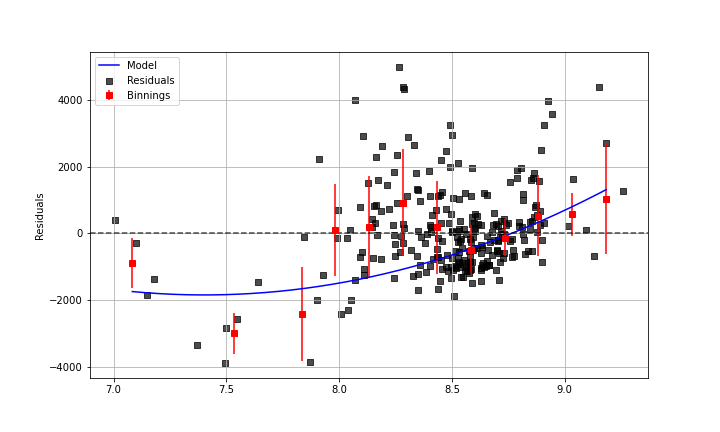

Parámetros ajustados: a = 995.1907388570959, b = -14733.108685881429, c = 52682.14823317693


In [32]:
### Vamos a ajustar a una función a nuestros resultados del binning donde los parametros seran los errores de nuestros \
### Parametros iniciales:

#Ajuste 
def quadratic_model_binning(O, M, std):
    
    #Definimos mascaras:
    mask = ~np.isnan(M) & ~np.isnan(std)
    O_mask = O[mask]
    M_mask = M[mask]
    std_mask = std[mask]
    
    #Definimos modelo:
    
    def quadratic_func(x, a, b, c):
        return a * x**2 + b * x + c

    # Ajuste de la función cuadrática
    popt, pcov = curve_fit(quadratic_func, O_mask, M_mask, sigma = std_mask, absolute_sigma=True)
    #poly = np.polyfit(O_mask, M_mask,2, w = 1/std_mask)

    # Parámetros ajustados
    a, b, c = popt
    #a,b,c = poly
    
    fig, ax = plt.subplots(figsize= (10,6))
    
    #Residuos:
    
    plt.scatter(df_new2['O_abundance'], Residual_Quadratic_Poly, color='black', marker = 's', alpha=0.7, label="Residuals")
    
    #Binnings:
    ax.errorbar(binninas[0], binninas[1], yerr = binninas[2], color='red',fmt = 's', label='Binnings')
    
    #Modelo:
    x_fit = np.linspace(min(binninas[0]), max(binninas[0]), 500)
    
    plt.plot(x_fit, np.dot(np.vander(x_fit, 3), [popt[0],popt[1],popt[2]]), color ='blue', label = 'Model' )
    
    plt.axhline(0, color='k', linestyle='dashed', alpha=0.7)
    plt.ylabel('Residuals')
    plt.legend(loc = 'best')
    plt.grid(True)
    plt.show()
    plt.savefig('Binnings', dpi = 500)
    return print(f"Parámetros ajustados: a = {a}, b = {b}, c = {c}")

model_binning = quadratic_model_binning(binninas[0], binninas[1], binninas[2])
model_binning

### Ajuste Cubico con ODR:

(4.284491151612408e-12, 1.507043334771117e-13, -1.661966589384171e-07, 3.785292454816012e-09, 0.0019208640602636883, 2.248996215214555e-05, 1.6888759302911411, 0.0, -0.7681107680449984)


<IPython.core.display.Javascript object>


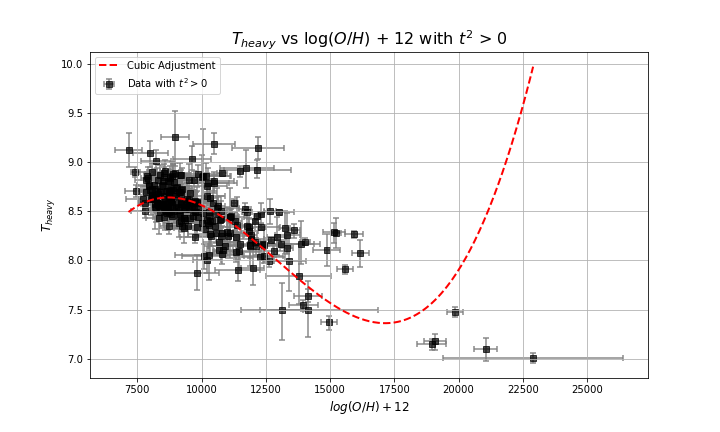

In [60]:
#esta funcion es para hacer ajustes cubicos considerando barras de error
def linfit3(x, y, xerr_low, xerr_high, yerr_low, yerr_high): #definimos función
    
    #Definemos nuestros errores como:
    
    x_e = (xerr_low + xerr_high)/2
    y_e = (yerr_low + yerr_high)/2
    
    #definimos la forma de la funcion que queremos ajustar, en este caso, cuadratica
    
    def cubic(theta,x):
        a, b, c, d = theta
        model = a*x**3 + b*x**2 + c*x + d
        return model
 
    cubic_model = odr.Model(cubic)
    
    # Create a RealData object
    data = odr.RealData(x, y, sx=x_e, sy=y_e)

    # Set up ODR with the model and data.
    odr_instance = odr.ODR(data, cubic_model, beta0=[2000, 1., 1., 1.])

    # Run the regression.
    out = odr_instance.run()

    #print fit parameters and 1-sigma estimates
    popt = out.beta
    perr = out.sd_beta
    
    a=popt[0]
    e_a=perr[0]
    
    b=popt[1]
    e_b=perr[1]
    
    c = popt[2]
    e_c = perr[2]
    
    d = popt[3]
    e_d = perr[3]
    

    # Calculate Pearson correlation coefficient
    correlation_coefficient, _ = stats.pearsonr(x, y)
    
    return  a, e_a, b, e_b, c, e_c, d, e_d, correlation_coefficient

#Hacemos nuestro ajuste cuadratico:

cubic = linfit3(df_new2['T_heavy'], df_new2['O_abundance'],df_new2['e_T'],df_new2['E_T'],df_new2['e_O_abundancem'],
                df_new2['e_O_abundancep']) #Le damos los valores a la función
print(cubic)

x = np.linspace(min(df_new2['T_heavy']), max(df_new2['T_heavy']), len(df_new2['T_heavy']))

#Graficamos:

fig, ax = plt.subplots(figsize=(10,6))

ax.errorbar(df_new2['T_heavy'], df_new2['O_abundance'], xerr = xerr, yerr = yerr,fmt ='s', c = 'k', elinewidth = 2, 
            capsize=3, capthick = 2, ecolor= 'grey', label = r'Data with $t^2 > 0$', alpha = 0.7, zorder = 1)

plt.plot(x, np.dot(np.vander(x, 4), [cubic[0], cubic[2], cubic[4], cubic[6]] ),'--', c = 'r', lw = 2, \
         label = 'Cubic Adjustment',  zorder = 2)

#print(f"a: {quadratic[0]:.4f} ± {quadratic[1]:.4f}") #Valor de a y su error
#print(f"b: {quadratic[2]:.4f} ± {quadratic[3]:.4f}") #Valor de b y su error
#print(f"c: {quadratic[4]:.4f} ± {quadratic[5]:.4f}") #Valor de c y sy error

ax.set_xlabel(r'$log(O/H) + 12$', size = 12)
ax.set_ylabel(r'$T_{heavy}$', size = 12)
ax.set_title('$T_{heavy}$ vs $\log(O/H)$ + 12 with $t^2$ > 0', size = 16)
plt.grid(True)
plt.legend()
#plt.savefig('Cubic_Adjustment_OvsTheavy_t2geq0', dpi = 500)

#### Ajuste a la Cuarta con ODR:

(11615.019322627637, 3425.381285666454, -368254.0180767408, 112023.13634202648, 4369062.6384640625, 1371869.9160109197, -22997388.134855844, 7455482.411076334, 45345144.35167899, 15169510.546297695, -0.7681108011290577)


<IPython.core.display.Javascript object>


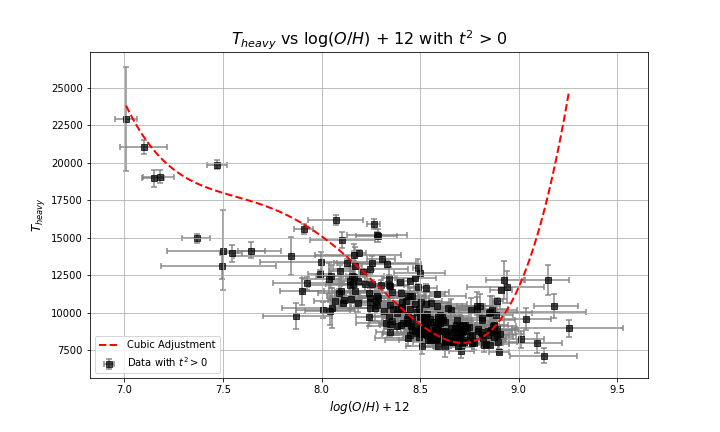

In [17]:
#esta funcion es para hacer ajustes cubicos considerando barras de error
def linfit4(x, y, xerr_low, xerr_high, yerr_low, yerr_high): #definimos función
    
    #Definemos nuestros errores como:
    
    x_e = (xerr_low + xerr_high)/2
    y_e = (yerr_low + yerr_high)/2
    
    #definimos la forma de la funcion que queremos ajustar, en este caso, cuadratica
    
    def cuarta(theta,x):
        a, b, c, d, e  = theta
        model = a*x**4 + b*x**3 + c*x**2 + d*x + e
        return model
 
    cuarta_model = odr.Model(cuarta)
    
    # Create a RealData object
    data = odr.RealData(x, y, sx=x_e, sy=y_e)

    # Set up ODR with the model and data.
    odr_instance = odr.ODR(data, cuarta_model, beta0=[0., 1., 1., 1., 1.])

    # Run the regression.
    out = odr_instance.run()

    #print fit parameters and 1-sigma estimates
    popt = out.beta
    perr = out.sd_beta
    
    a=popt[0]
    e_a=perr[0]
    
    b=popt[1]
    e_b=perr[1]
    
    c = popt[2]
    e_c = perr[2]
    
    d = popt[3]
    e_d = perr[3]
    
    e = popt[4]
    e_e = perr[4]
    

    # Calculate Pearson correlation coefficient
    correlation_coefficient, _ = stats.pearsonr(x, y)
    
    return  a, e_a, b, e_b, c, e_c, d, e_d, e, e_e, correlation_coefficient

#Hacemos nuestro ajuste cuadratico:

cuarto = linfit4(df_new2['O_abundance'], df_new2['T_heavy'], df_new2['e_O_abundancem'], df_new2['e_O_abundancep'], 
                    df_new2['e_T'],df_new2['E_T']) #Le damos los valores a la función
print(cuarto)

x = np.linspace(min(df_new2['O_abundance']), max(df_new2['O_abundance']), len(df_new2['O_abundance']))

#Graficamos:

fig, ax = plt.subplots(figsize=(10,6))

ax.errorbar(df_new2['O_abundance'], df_new2['T_heavy'], xerr = xerr2, yerr = yerr2,fmt ='s', c = 'k', elinewidth = 2, 
            capsize=3, capthick = 2, ecolor= 'grey', label = r'Data with $t^2 > 0$', alpha = 0.7, zorder = 1)

plt.plot(x, np.dot(np.vander(x, 5), [cuarto[0], cuarto[2], cuarto[4], cuarto[6], cuarto[8]] ),'--', c = 'r', lw = 2, \
         label = 'Cubic Adjustment',  zorder = 2)

#print(f"a: {quadratic[0]:.4f} ± {quadratic[1]:.4f}") #Valor de a y su error
#print(f"b: {quadratic[2]:.4f} ± {quadratic[3]:.4f}") #Valor de b y su error
#print(f"c: {quadratic[4]:.4f} ± {quadratic[5]:.4f}") #Valor de c y sy error

ax.set_xlabel(r'$log(O/H) + 12$', size = 12)
ax.set_ylabel(r'$T_{heavy}$', size = 12)
ax.set_title('$T_{heavy}$ vs $\log(O/H)$ + 12 with $t^2$ > 0', size = 16)
plt.grid(True)
plt.legend()
#plt.savefig('Cubic_Adjustment_OvsTheavy_t2geq0', dpi = 1000)